In [1]:
import pandas as pd
import numpy as np

In [2]:

# df = pd.read_csv('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/data_2.csv', sep = " ", names = ['name', 'value'])

df = pd.read_csv('/home/ana/Documents/Code/Flexible-Tool/data_2.csv', sep = " ", names = ['name', 'value'])


In [3]:

df.dropna(inplace = True)
df


,name,value
0,a,[0.6152792 0.57624728 0.97183159 0.30227324 0...
1,q,"[[1.0, 0.99996588008, 0.99989695401, 0.9997925..."
2,det_J,"[0.0, 0.0, 0.0, 0.0, -2.53263925567196e-87, 2...."
3,a,[0.42157321 0.04321076 0.28883865 0.53631535 0...
4,q,"[[1.0, 0.99999984126, 0.99999948152, 0.9999988..."
...,...,...
2995,q,"[[1.0, 0.99991970255, 0.99975684995, 0.9995091..."
2996,det_J,"[0.0, 0.0, 0.0, 0.0, 1.4138451607417442e-86, -..."
2997,a,[0.18525751 0.06743073 0.86360801 0.0865571 0...
2998,q,"[[1.0, 0.99999969828, 0.9999992522, 0.99999881..."


In [4]:
df2 = pd.DataFrame()
for r in range(len(df)):
    if r % 3 == 0:
        df0 = df.iloc[r,1:]
        df0.value
        df0 = df0.str.strip('[[[ ')
        df0 = df0.str.strip('[]')
        df0 = df0.value.split()
        df0 = np.array(df0,dtype=float)
        df2 = df2.append(pd.DataFrame(df0))




In [5]:
df2.head(12)
df2.shape

(6000, 1)

In [6]:
df2.shape

(6000, 1)

In [7]:
df3 = pd.DataFrame()
for i in range(len(df)):
    if i % 3 == 1:
        df1 = df.iloc[i,1:]
        df1 = df1.value
        df1 = df1.replace('[','')
        df1 = df1.replace(']','')
        df1 = df1.split(',')
        df1 = np.array(df1,dtype=float)
        df3 = df3.append(pd.DataFrame(df1))


In [8]:
df3.shape

(1600000, 1)

In [9]:
type(df3)

pandas.core.frame.DataFrame

In [10]:
q_array = df3.to_numpy()
tmp = []
for r in q_array:
    tmp.append(np.transpose(np.asarray([r])).astype(np.float32))
q_array = np.asarray(tmp.copy())
type(q_array)

numpy.ndarray

In [11]:
q_array = q_array.reshape(1000,16,100)
q_array.shape

(1000, 16, 100)

In [12]:
a_array = df2.to_numpy()
tmp2 = []
for i in a_array:
    tmp2.append(np.transpose(np.asarray([i])).astype(np.float32))
a_array = np.asarray(tmp2.copy())

In [13]:
a_array = a_array.reshape(1000,6)
a_array.shape

(1000, 6)

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [15]:
train_x = (q_array[0:800,:,:]).astype(np.float32) # training data from csv/pandas (80% of existing data?)
test_x = (q_array[800:1000,:,:]).astype(np.float32) # test data from csv/pandas (remaining ~20% of data)
test_x = np.expand_dims(test_x, 1) # add dimension for neural net

train_y = (a_array[0:800,:]).astype(np.float32)
test_y = (a_array[800:1000,:]).astype(np.float32)

x_test_tensor = torch.from_numpy(test_x)
y_test_tensor = torch.from_numpy(test_y)
test_data = [(x_test_tensor[i],y_test_tensor[i]) for i in range(x_test_tensor.shape[0])]

# print(train_x.shape)
# print(x_test_tensor.shape)
# print(y_test_tensor.shape)
# print(len(test_data))


In [16]:
x_train_tensor = torch.from_numpy(train_x)
y_train_tensor = torch.from_numpy(train_y)

# xtrain_tensor = torch.utils.data.TensorDataset(train_x)
# ytrain_tensor = torch.utils.data.TensorDataset(train_y)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, 
                                             shuffle=True)


for batch, (x, y) in enumerate(train_loader):
    print("batch", batch)
    print("Shape of x: ", x.shape, x.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break


# trainset_x = torch.utils.data.DataLoader(train_x, batch_size=10, shuffle=True)
# testset_x = torch.utils.data.DataLoader(test_x, batch_size=10, shuffle=True)
# trainset_y = torch.utils.data.DataLoader(train_y, batch_size=10, shuffle=True)
# testset_y = torch.utils.data.DataLoader(test_y, batch_size=10, shuffle=True)

batch 0
Shape of x:  torch.Size([100, 16, 100]) torch.float32
Shape of y:  torch.Size([100, 6]) torch.float32


In [17]:
import torch.nn.functional as F

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
#             nn.Conv1d(16, 50, 100, padding='same'), # in_channels, out_channels, kernel_size, stride, padding
#             nn.Flatten(),
            nn.Linear(16*100, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.linear_stack(x)
        return output

model = Net()
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [19]:
### loss function and optimizer for training 
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Functions for training and testing the model
def train(dataloader, model, loss_fn, optimizer,loss_list):
    size = len(dataloader.dataset)
    for batch, (x,y) in enumerate(dataloader):

#         print("batch ", batch)
#         print("Shape of x: ", x.shape)
#         print("Shape of y: ", y.shape)
    
        # Compute prediction error
        pred = model(x)
#         print("pred", pred)
#         print("y", y)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
        if batch % 2 == 0:
#             loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model,test_loss_list):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
#             print("pred",pred.shape)
#             print("y",y.shape)
            test_loss += loss_fn(pred, y)
    print(f"Test Error: Loss = {test_loss:>8f} \n")
    test_loss_list.append(test_loss)
    return test_loss_list

In [20]:
### Train the model
epochs = 10
loss_list=[]
test_loss_list=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_list = train(train_loader, model, loss_fn, optimizer,loss_list)
    test_loss_list = test(test_loader, model, test_loss_list)
    


Epoch 1
-------------------------------
loss: 0.424764  [    0/  800]
loss: 0.379964  [  200/  800]
loss: 0.357456  [  400/  800]
loss: 0.315320  [  600/  800]
Test Error: Loss = 0.608511 

Epoch 2
-------------------------------
loss: 0.298308  [    0/  800]
loss: 0.292669  [  200/  800]
loss: 0.249860  [  400/  800]
loss: 0.240213  [  600/  800]
Test Error: Loss = 0.460989 

Epoch 3
-------------------------------
loss: 0.239031  [    0/  800]
loss: 0.215007  [  200/  800]
loss: 0.195845  [  400/  800]
loss: 0.203713  [  600/  800]
Test Error: Loss = 0.362103 

Epoch 4
-------------------------------
loss: 0.175567  [    0/  800]
loss: 0.173344  [  200/  800]
loss: 0.148121  [  400/  800]
loss: 0.158144  [  600/  800]
Test Error: Loss = 0.295889 

Epoch 5
-------------------------------
loss: 0.141610  [    0/  800]
loss: 0.143574  [  200/  800]
loss: 0.141568  [  400/  800]
loss: 0.131372  [  600/  800]
Test Error: Loss = 0.251796 

Epoch 6
-------------------------------
loss: 0.12

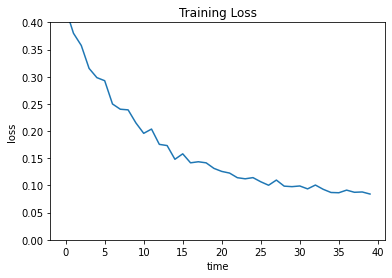

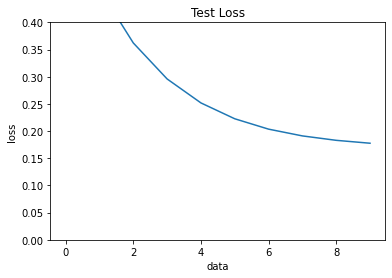

In [21]:
plt.figure()
plt.plot(loss_list)
axes = plt.gca()
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('loss')
axes.set_ylim([0,0.4])
plt.show()

plt.figure()
plt.plot(test_loss_list)
axes = plt.gca()
plt.title('Test Loss')
plt.xlabel('data')
plt.ylabel('loss')
axes.set_ylim([0,0.4])
plt.show()